In [14]:
from trainValTestGreyscale import getData
import logging
import os
import sys
import tempfile
from glob import glob
from natsort import natsorted
import random
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandFlipd,
    Rand2DElasticd,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
    RandGaussianNoised
)
from monai.visualize import plot_2d_or_3d_image
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType, KeepLargestConnectedComponent, FillHoles
from monai.networks.nets import UNet
import warnings
from typing import Sequence, Union

import torch

from monai.metrics.utils import do_metric_reduction, ignore_background
from monai.utils import MetricReduction, ensure_tuple
from monai.metrics import confusion_matrix
from monai.metrics import CumulativeIterationMetric

In [15]:
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        RandFlipd(keys=["img", "seg"], prob=1, spatial_axis=0),
        EnsureTyped(keys=["img", "seg"]),  
    ]
)

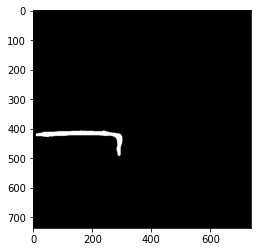

In [16]:
# Get Data
import matplotlib.pyplot as plt
_, _, val_images, val_segs, test_images, test_segs = getData.getImageSegTrainValTest("ALL")

test_files = [{"img": img, "seg": seg}
                for img, seg in zip(test_images, test_segs)]

test_ds = monai.data.Dataset(data=test_files, transform=train_transforms)
test_loader = DataLoader(test_ds, batch_size=1,
                        num_workers=4, collate_fn=list_data_collate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#threshold = 0.5
test_iter = iter(test_loader)
for i, data in enumerate(test_iter):
  img, label = data["img"].to(
                device), data["seg"].to(device)
  val_outputs = label[0][0].cpu()
  plt.figure()
  plt.imshow((val_outputs), cmap = "gray")
  break